# Dask Dataframes

*[Dask](http://dask.pydata.org) is a flexible parallel computing library for analytic computing* written in Python. Dask is similar to Spark, by lazily constructing directed acyclic graph (DAG) of tasks and splitting large datasets into small portions called partitions. See the below image from [Dask's web page](http://dask.pydata.org) for illustration. 

![http://dask.pydata.org/en/latest/_images/collections-schedulers.png](images/collections-schedulers.png) 

It has three main interfaces:

* [Array](http://dask.pydata.org/en/latest/array.html), which works like [NumPy](http://www.numpy.org/) arrays;
* [Bag](http://dask.pydata.org/en/latest/bag.html), which is similar to RDD interface in Spark;
* [DataFrame](http://dask.pydata.org/en/latest/dataframe.html), which works like [Pandas](https://pandas.pydata.org/) DataFrame.

While it can work on a [distributed cluster](http://dask.pydata.org/en/latest/distributed.html), Dask works also very well on a single cpu machine.

## DataFrames

Dask dataframes look and feel (mostly) like Pandas dataframes but they run on the same infrastructure that powers dask.delayed.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

In this notebook, we will extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is taken from [here](http://stat-computing.org/dataexpo/2009/the-data.html). This should only take a few seconds to run.

We will use `dask.dataframe` construct our computations for us.  The `dask.dataframe.read_csv` function can take a globstring like `"data/nycflights/*.csv"` and build parallel computations on all of our data at once.

### Prep the Data

In [1]:
import os
import pandas as pd
pd.set_option("max.rows", 10)
os.getcwd()

'/home/runner/work/big-data/big-data/notebooks'

In [2]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_flight():
    here = os.getcwd()
    flightdir = os.path.join(here,'data', 'nycflights')
    if not os.path.exists(flightdir):
       print("Extracting flight data")
       tar_path = os.path.join('data', 'nycflights.tar.gz')
       with tarfile.open(tar_path, mode='r:gz') as flights:
          flights.extractall('data/')
            
extract_flight() # this function call will extract 10 csv files in data/nycflights

Extracting flight data


### Load Data from CSVs in Dask Dataframes

In [3]:
import os
here = os.getcwd()
filename = os.path.join(here, 'data', 'nycflights', '*.csv')
filename

'/home/runner/work/big-data/big-data/notebooks/data/nycflights/*.csv'

In [4]:
import dask
import dask.dataframe as dd

df = dd.read_csv(filename,
                 parse_dates={'Date': [0, 1, 2]})

Let's take a look to the dataframe

In [5]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
### Get the first 5 rows
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [7]:
import traceback # we use traceback because we except an error.

try:
    df.tail() # Get the last 5 rows
except Exception:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-7-7cb27b738c02>", line 4, in <module>
    df.tail() # Get the last 5 rows
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/dataframe/core.py", line 1054, in tail
    result = result.compute()
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/base.py", line 167, in compute
    (result,) = compute(self, traverse=False, **kwargs)
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/base.py", line 452, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/threaded.py", line 84, in get
    **kwargs
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/local.py", line 486, in get_async
    raise_exception(exc, tb)
  File "/usr/share/miniconda3/envs/big-data/lib/python3.7/site-packages/dask/local.py", line 316, in reraise
    raise exc
  File "/usr/share/mini

### What just happened?

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns.

In [8]:
df.dtypes

Date          datetime64[ns]
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
                   ...      
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
Length: 21, dtype: object

In [9]:
df = dd.read_csv(filename,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [10]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


Let's take a look at one more example to fix ideas.

In [11]:
len(df)

2611892

### Why df is ten times longer ?

- Dask investigated the input path and found that there are ten matching files. 
- A set of jobs was intelligently created for each chunk - one per original CSV file in this case. 
- Each file was loaded into a pandas dataframe, had `len()` applied to it.
- The subtotals were combined to give you the final grant total.

## Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column.  With `dask.delayed` we could create this computation as follows:

```python
maxes = []
for fn in filenames:
    df = dask.delayed(pd.read_csv)(fn)
    maxes.append(df.DepDelay.max())
    
final_max = dask.delayed(max)(maxes)
final_max.compute()
```

Now we just use the normal Pandas syntax as follows:

In [12]:
%time df.DepDelay.max().compute()

CPU times: user 3.83 s, sys: 415 ms, total: 4.24 s
Wall time: 2.83 s


1435.0

This writes the delayed computation for us and then runs it. Recall that the delayed computation is a dask graph made of up of key-value pairs.

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

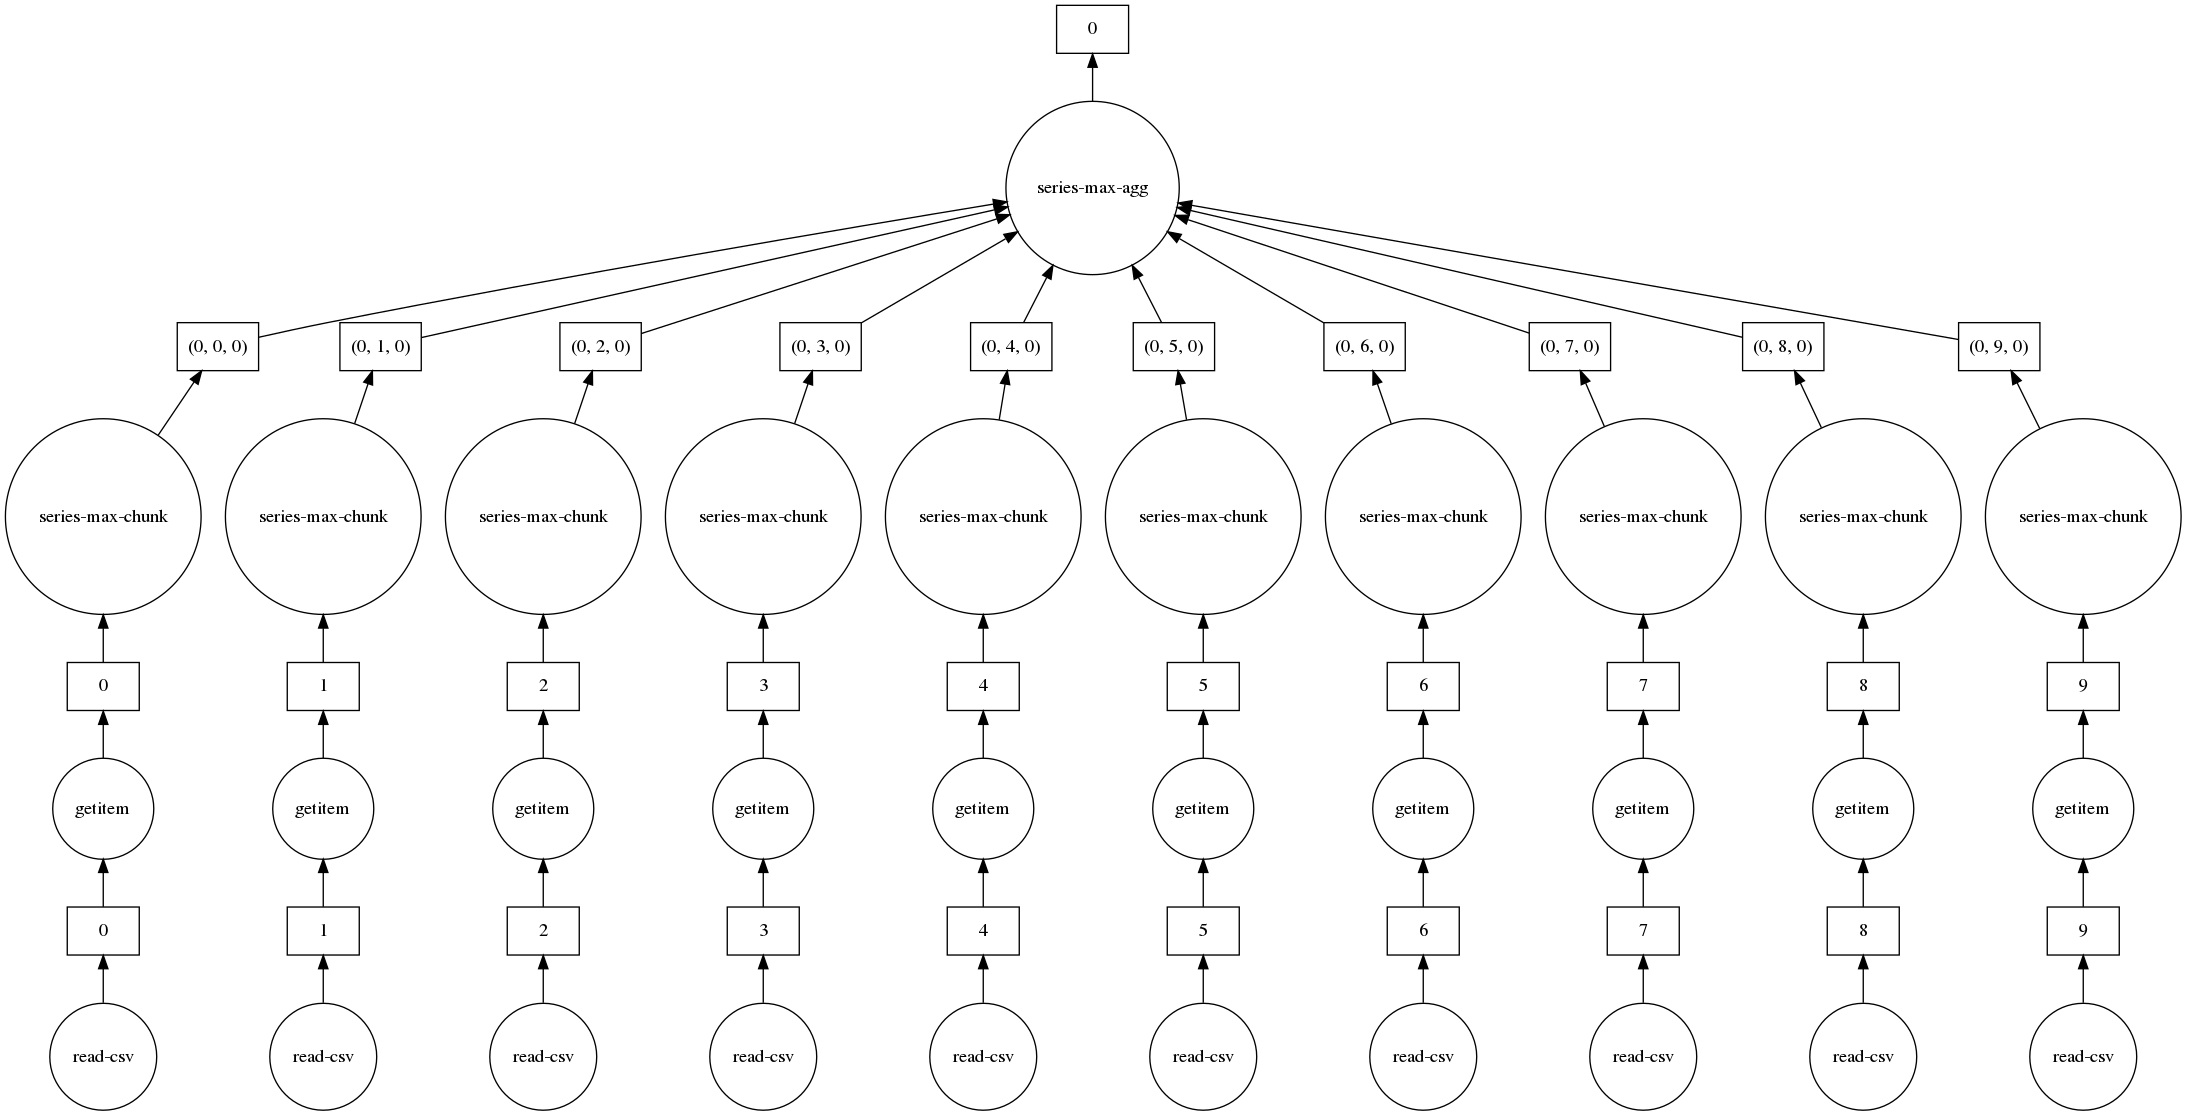

In [13]:
df.DepDelay.max().visualize()

If you are already familiar with the Pandas API then know how to use `dask.dataframe`.  There are a couple of small changes.

As noted above, computations on dask `DataFrame` objects don't perform work, instead they build up a dask graph.  We can evaluate this dask graph at any time using the `.compute()` method.

In [14]:
result = df.DepDelay.mean()  # create the tasks graph

In [15]:
%time result.compute()           # perform actual computation

CPU times: user 3.9 s, sys: 381 ms, total: 4.28 s
Wall time: 2.87 s


9.206602541321965

## Store Data in Apache Parquet Format

Dask encourage dataframe users to store and load data using Parquet instead. [Apache Parquet](http://parquet.apache.org/) is a columnar binary format that is easy to split into multiple files (easier for parallel loading) and is generally much simpler to deal with than HDF5 (from the Dask library’s perspective). It is also a common format used by other big data systems like [Apache Spark](http://spark.apache.org/) and [Apache Impala](http://impala.apache.org/) and so is useful to interchange with other systems.

In [16]:
df.drop("TailNum", axis=1).to_parquet("nycflights/")  # save csv files using parquet format

It is possible to specify dtypes and compression when converting. This can definitely help give you significantly greater speedups, but just using the default settings will still be a large improvement.

In [17]:
df.size.compute()

54849732

In [18]:
import dask.dataframe as dd
df = dd.read_parquet("nycflights/")
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,86.0,81.0,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,73.0,81.0,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,84.0,81.0,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,88.0,81.0,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,77.0,81.0,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [19]:
result = df.DepDelay.mean() 

In [20]:
%time result.compute() 

CPU times: user 122 ms, sys: 25 ms, total: 147 ms
Wall time: 99.1 ms


9.206602541321965

The computation is much faster because pulling out the DepDelay column is  easy for Parquet.

### Parquet advantages:

- Binary representation of data, allowing for speedy conversion of bytes-on-disk to bytes-in-memory
- Columnar storage, meaning that you can load in as few columns as you need without loading the entire dataset
- Row-chunked storage so that you can pull out data from a particular range without touching the others
- Per-chunk statistics so that you can find subsets quickly
- Compression

### Exercise 15.1

If you don't remember how to use pandas.  Please read [pandas documentation](http://pandas.pydata.org/).

- Use the `head()` method to get the first ten rows
- How many rows are in our dataset?
- Use selections `df[...]` to find how many positive (late) and negative (early) departure times there are
- In total, how many non-cancelled flights were taken? (To invert a boolean pandas Series s, use ~s).

Divisions and the Index
---------------------------

The Pandas index associates a value to each record/row of your data.  Operations that align with the index, like `loc` can be a bit faster as a result.

In `dask.dataframe` this index becomes even more important.  Recall that one dask `DataFrame` consists of several Pandas `DataFrame`s.  These dataframes are separated along the index by value.  For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas `DataFrames` on demand.

Partitioning your data can greatly improve efficiency.  Operations like `loc`, `groupby`, and `merge/join` along the index are *much more efficient* than operations along other columns.  You can see how your dataset is partitioned with the `.divisions` attribute.  Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default.  In these cases the values for `.divisions` will be `None.`

In [21]:
df = dd.read_csv(filename,
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df.divisions

(None, None, None, None, None, None, None, None, None, None, None)

However if we set the index to some new column then dask will divide our data roughly evenly along that column and create new divisions for us.  Warning, `set_index` triggers immediate computation.

In [22]:
df2 = df.set_index('Year')
df2.divisions

(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 1999)

We see here the minimum and maximum values (1990 and 1999) as well as the intermediate values that separate our data well.  This dataset has ten partitions, as the final value is assumed to be the inclusive right-side for the last bin.

In [23]:
df2.npartitions

10

In [24]:
df2.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Year,,,,,,,,,,,,,,,,,,,,,
1990,1,1,1,1621.0,1540,1747.0,1701,US,33,NaN,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,2,2,1547.0,1540,1700.0,1701,US,33,NaN,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,3,3,1546.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,4,4,1542.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,5,5,1549.0,1540,1706.0,1701,US,33,NaN,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


One of the benefits of this is that operations like `loc` only need to load the relevant partitions

In [25]:
df2.loc[1991]

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=1,,,,,,,,,,,,,,,,,,,,,,
1991,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
1991,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [26]:
df2.loc[1991].compute()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Year,,,,,,,,,,,,,,,,,,,,,
1991,1,8,2,1215.0,1215,1340.0,1336,US,121,NaN,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,False,0
1991,1,9,3,1215.0,1215,1353.0,1336,US,121,NaN,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,False,0
1991,1,10,4,1216.0,1215,1332.0,1336,US,121,NaN,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,False,0
1991,1,11,5,1303.0,1215,1439.0,1336,US,121,NaN,...,NaN,63.0,48.0,EWR,PIT,319.0,NaN,NaN,False,0
1991,1,12,6,1215.0,1215,1352.0,1336,US,121,NaN,...,NaN,16.0,0.0,EWR,PIT,319.0,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,12,26,4,1600.0,1600,1857.0,1906,CO,1539,NaN,...,NaN,-9.0,0.0,LGA,FLL,1076.0,NaN,NaN,False,0
1991,12,27,5,1600.0,1600,1853.0,1906,CO,1539,NaN,...,NaN,-13.0,0.0,LGA,FLL,1076.0,NaN,NaN,False,0
1991,12,28,6,1600.0,1600,1856.0,1906,CO,1539,NaN,...,NaN,-10.0,0.0,LGA,FLL,1076.0,NaN,NaN,False,0


### Exercises 15.2

In this section we do a few `dask.dataframe` computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call `compute`.

- In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html). `df.groupby(df.A).B.func()`.

- What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

- What day of the week has the worst average departure delay?

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-cancelled flights:

In [27]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

#### Using two calls to `.compute`:

In [28]:
%%time
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 7.29 s, sys: 340 ms, total: 7.63 s
Wall time: 4.59 s


#### Using one call to `dask.compute`:

In [29]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 3.63 s, sys: 173 ms, total: 3.81 s
Wall time: 2.29 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to zoom in on the graph better):

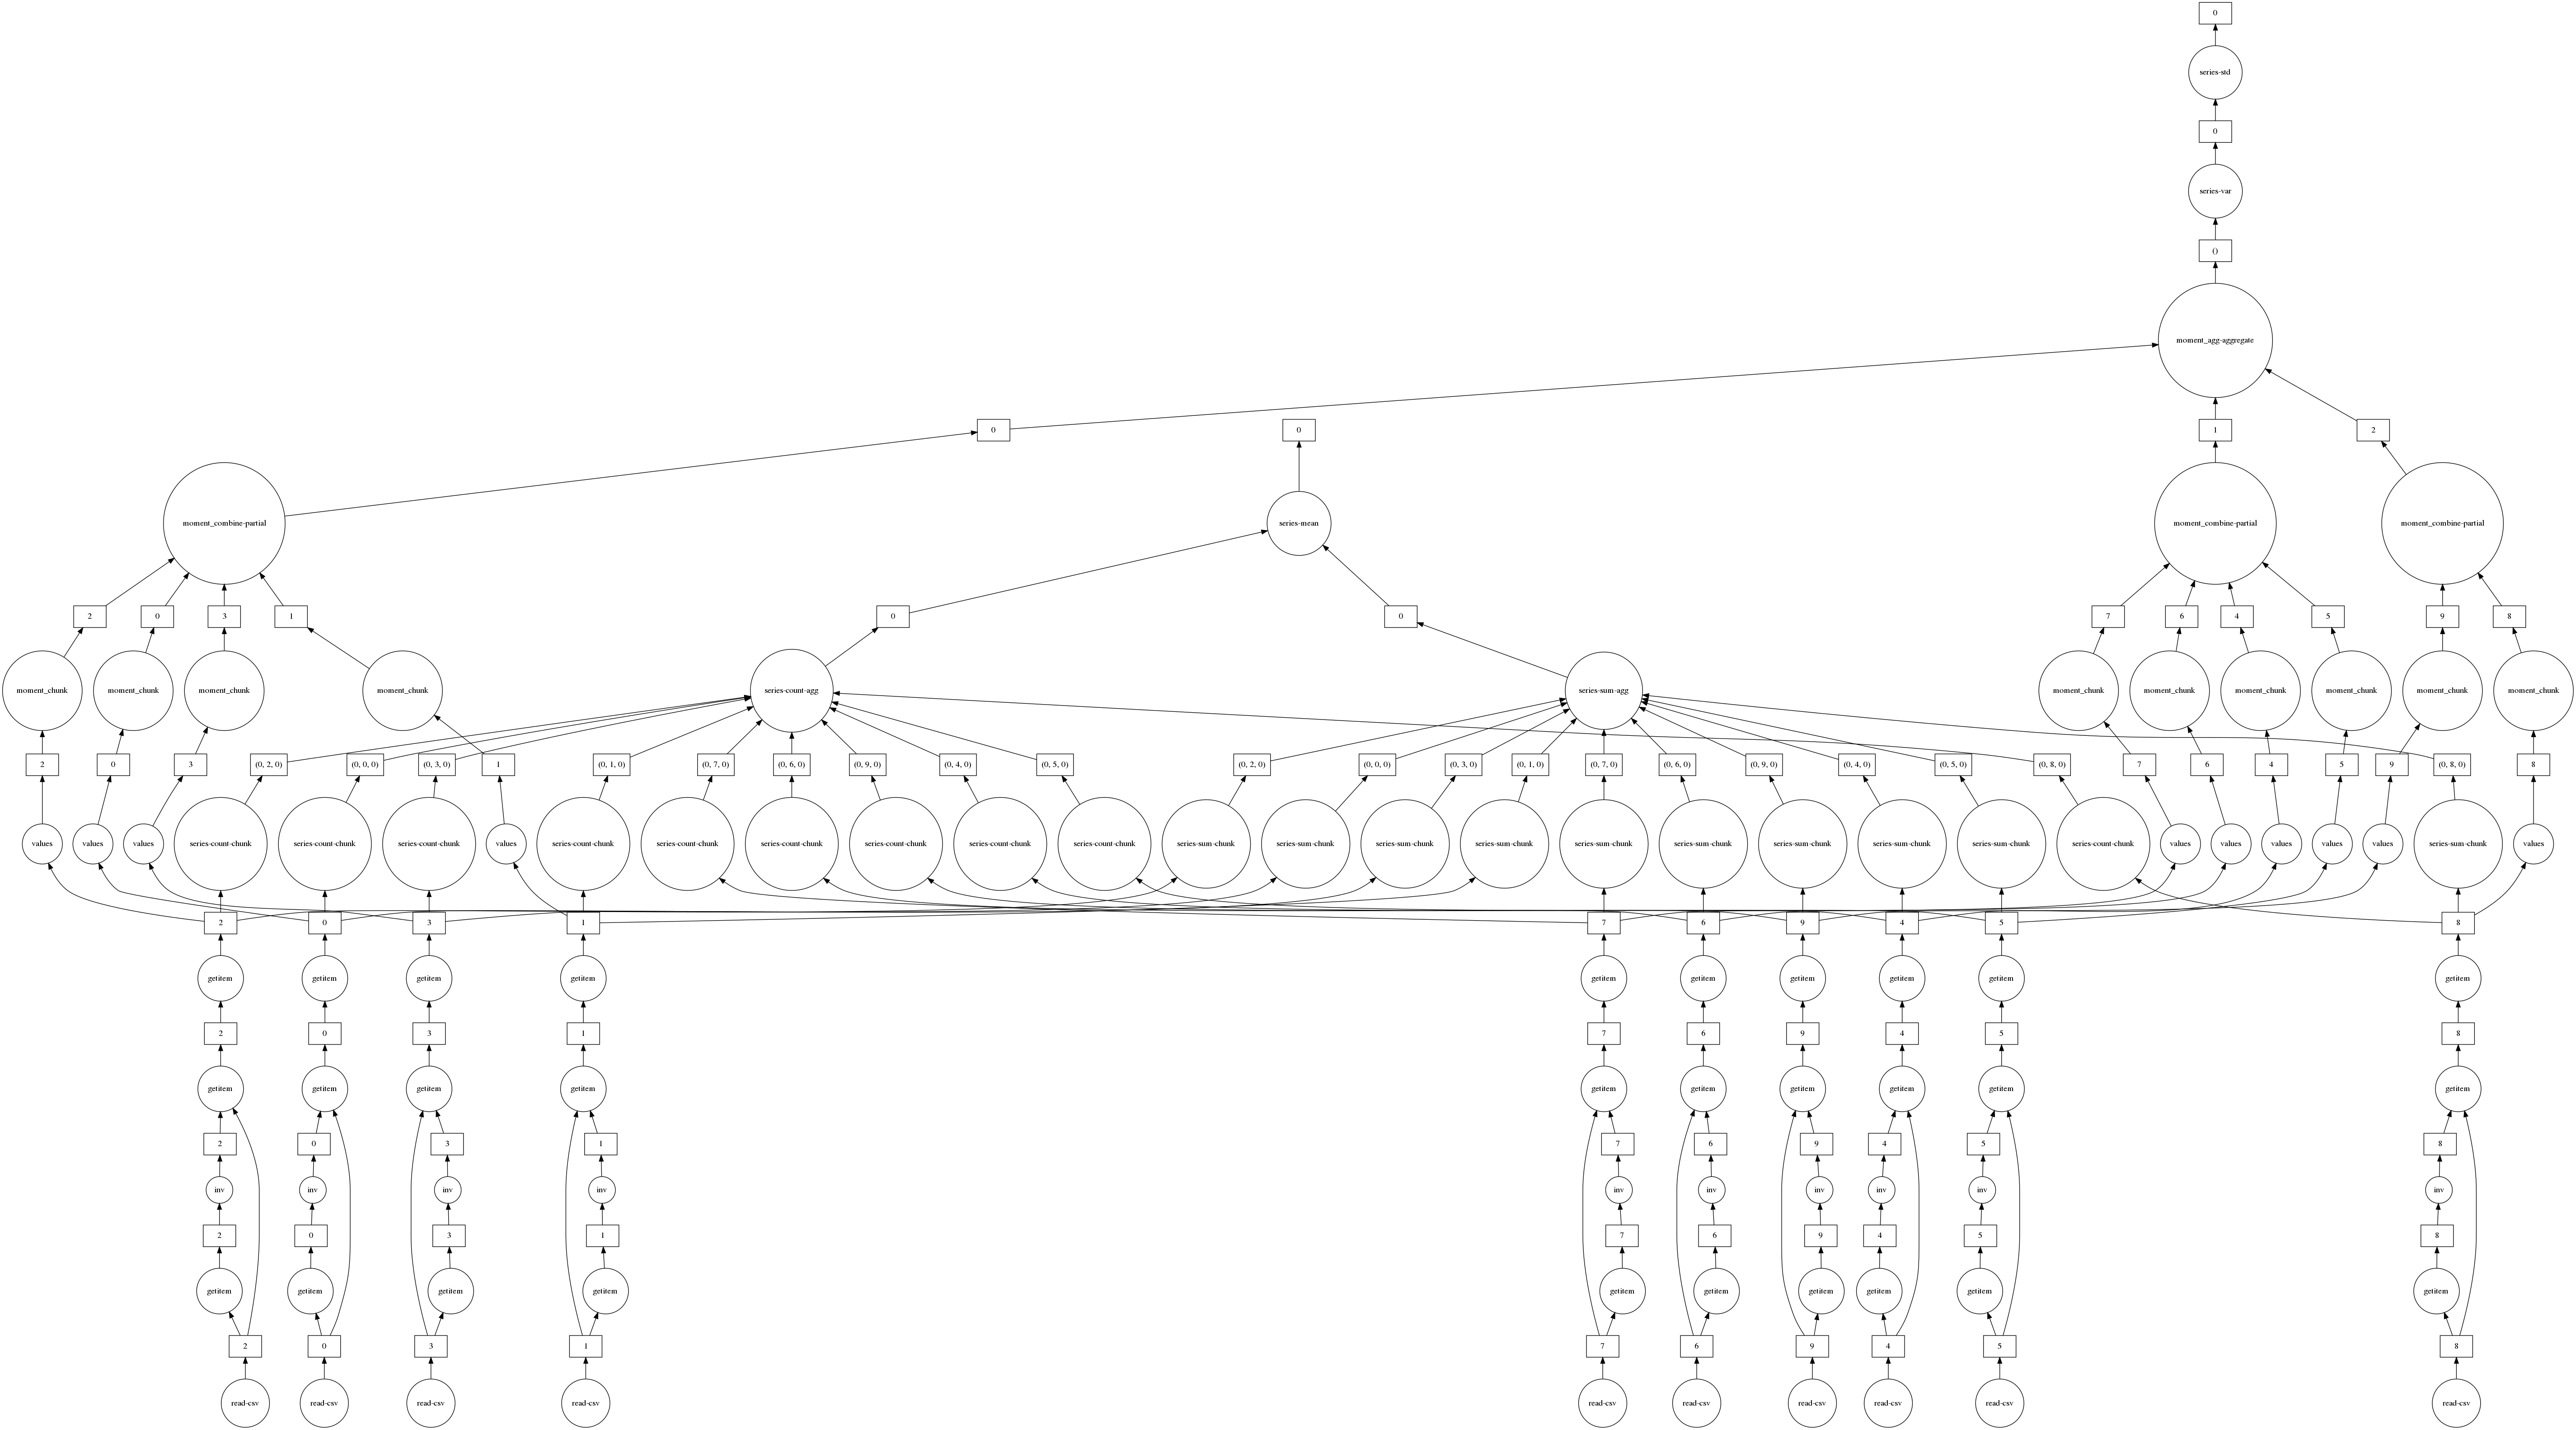

In [30]:
dask.visualize(mean_delay, std_delay)